In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import json
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import nltk
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import decomposition, ensemble
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from itertools import product
nltk.download('punkt')
np.random.seed(0)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcschneider/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip install imblearn

In [3]:
#retrieving the url for FOMC Statement
html_page= requests.get('https://www.federalreserve.gov/newsevents/pressreleases/monetary20190320a.htm') 
soup= BeautifulSoup(html_page.content, 'html.parser')

In [4]:
#preview the soup... MMM soup
print(soup.prettify()[:1000])

<!DOCTYPE doctype html>
<html class="no-js" lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1.0, minimum-scale=1.0 maximum-scale=1.6, user-scalable=1" name="viewport"/>
  <meta content=" Information received since the Federal Open Market Committee met in January indicates that the labor market remains strong but that growth of economic activity" name="description">
   <meta content="Federal Reserve issues FOMC statement" property="og:title">
    <meta content="Board of Governors of the Federal Reserve System" property="og:site_name">
     <meta content="article" property="og:type"/>
     <meta content=" Information received since the Federal Open Market Committee met in January indicates that the labor market remains strong but that growth of economic activity" property="og:description"/>
     <meta content="" property="og:image"/>
     <meta content="summary" name="twitter:card"/>


In [236]:
#search for the text in the article, isolate and save text
article = soup.find("div",attrs={"class":"col-xs-12 col-sm-8 col-md-8"}).getText()

In [237]:
# get json data from federal reserve 
r = requests.get('https://www.federalreserve.gov/json/ne-press.json')

In [238]:
# federal reserve json content
c = r.content

In [239]:
# clean up data using beautiful soup
json_file = BeautifulSoup(c)

In [240]:
# load data
json.loads(json_file.text[0:3568] + ']')

[{'d': '3/28/2019 4:30:00 PM',
  't': 'Federal Reserve Board releases document providing additional information on its stress testing program',
  'pt': 'Banking and Consumer Regulatory Policy',
  'l': '/newsevents/pressreleases/bcreg20190328a.htm'},
 {'d': '3/25/2019 2:00:00 PM',
  't': 'Federal and state financial regulatory agencies issue interagency statement on supervisory practices regarding financial institutions affected by flooding in the Midwest',
  'pt': 'Banking and Consumer Regulatory Policy',
  'l': '/newsevents/pressreleases/bcreg20190325a.htm'},
 {'d': '3/22/2019 5:00:00 PM',
  't': 'Federal Reserve Board announces approval of proposals by First Interstate Bank',
  'pt': 'Orders on Banking Applications',
  'l': '/newsevents/pressreleases/orders20190322a.htm'},
 {'d': '3/22/2019 12:00:00 PM',
  't': 'Federal Reserve System publishes annual financial statements',
  'pt': 'Other Announcements',
  'l': '/newsevents/pressreleases/other20190322a.htm'},
 {'d': '3/21/2019 12:00:

In [241]:
# split the data on "Federal Reserve issues FOMC statement"
our_list = json_file.text.split("Federal Reserve issues FOMC statement")

In [242]:
links = []
for element in our_list[1:]:
    links.append('https://www.federalreserve.gov/newsevents' + element.split('newsevents')[1][0:36])

In [243]:
documents=[]
for link in links:
    html_page= requests.get(link) 
    soup= BeautifulSoup(html_page.content, 'html.parser')
    article = soup.find("div",attrs={"class":"col-xs-12 col-sm-8 col-md-8"}).getText()
    documents.append(article)

In [244]:
listoftags=[]
for doc in documents:
    listoftags.append([doc,'dovish'])

In [245]:
df= pd.DataFrame(listoftags)

In [246]:
df.to_excel("FOMC.xlsx")

In [247]:
df=pd.read_excel("FOMC copy.xlsx")

In [248]:
df.drop(columns = 'Unnamed: 2', inplace= True)

In [249]:
df.columns = ["Documents", "Category"]

In [250]:
def clean_data(data):
    cleaned_data = []
    for line in data:
        if not '[' in line and not ']' in line:
            for symbol in ",.?!''\n":
                line = line.replace(symbol, '').lower()
            cleaned_data.append(line)
    return "".join(cleaned_data)
data_without_brackets = clean_data(df.Documents[0])

In [251]:
df['Documents']= df['Documents'].apply(lambda x: clean_data(x))

In [252]:
from nltk.corpus import stopwords
import re

In [253]:
stopwords_list = stopwords.words('english') + list(string.punctuation)

In [254]:
#This function returns a PARAGRAPH of words that have stopwords and numbers removed
def process_data(Documents):
    tokens = nltk.word_tokenize(Documents)
    stopwords_removed = ' '.join([token.lower() for token in tokens if token not in stopwords_list])
    pattern= r"[a-z]+"
    regex_tokens = re.findall(pattern, stopwords_removed)
    return ' '.join(regex_tokens)

In [255]:
document_words = df['Documents'].tolist()

In [256]:
category = df['Category'].tolist()

In [257]:
processed_data= list(map(process_data, document_words))

In [258]:
#Process the data for each document and create a new column in the data frame with the preprocessed data
corpus= []
for i in processed_data:
    corpus.append(i)

In [259]:
df['Processed_Data'] = np.nan

In [260]:
df['Processed_Data'] = df.apply(lambda x: corpus)

In [261]:
def tokenize(data):
    joined_data = ' '.join(data)
    tokenized_data = word_tokenize(data)
    
    return tokenized_data

tokenized_test_data = tokenize(df['Processed_Data'][0])

In [262]:
df['Tokenized_Data']= df['Processed_Data'].apply(lambda x: tokenize(x))

## Word Tokenize and Frequency Distributions

In [263]:
from nltk import word_tokenize, FreqDist

In [264]:
fdist = FreqDist()
for row in df['Tokenized_Data']:
    for word in row:
        fdist[word] += 1

In [265]:
count_vectorizer= CountVectorizer()

In [266]:
processed_words_df = pd.DataFrame(df['Tokenized_Data'])
categories_df = pd.DataFrame(category)

In [267]:
df_model= pd.concat([processed_words_df, categories_df], axis =1, sort= False)

In [268]:
df_model.columns= ['Statement_Words', 'Category']

In [269]:
def make_raw_doc(list_of_words):
    return ' '.join(list(list_of_words))

In [270]:
df_model['raw_document'] = df_model.Statement_Words.apply(lambda x: make_raw_doc(x))

In [271]:
df_model['binary_code']= pd.get_dummies(df_model['Category'], drop_first=True)

In [272]:
df_model.head()

,Statement_Words,Category,raw_document,binary_code
0,"[information, received, since, federal, open, ...",dovish,information received since federal open market...,0
1,"[information, received, since, federal, open, ...",dovish,information received since federal open market...,0
2,"[information, received, since, federal, open, ...",hawkish,information received since federal open market...,1
3,"[information, received, since, federal, open, ...",dovish,information received since federal open market...,0
4,"[information, received, since, federal, open, ...",hawkish,information received since federal open market...,1


In [273]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_model.raw_document, df_model.Category, train_size = .8, random_state = 0)

#do we need this


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [274]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train ,y_train)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(X_train)
xtest_count =  count_vect.transform(X_test)


## Count Vectorizing

In [275]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [276]:
from sklearn.feature_extraction.text import CountVectorizer

In [277]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=5000)
tfidf_vect_ngram.fit(X_train)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

In [278]:
#create a vectorizer to ultimate create a sparse matrix of our corpus
vectorizer = CountVectorizer()

In [279]:
#fits a model to our corpus
X = vectorizer.fit_transform(corpus)

## Endogeniety

In [280]:
sorted_wordsbyappearance = sorted(vectorizer.vocabulary_.items(), key=lambda kv: kv[1], reverse=True)

In [281]:
for i in sorted_wordsbyappearance:
    if i[1] > 800:
        stopwords_list.append(i[0])      

## Sparse Matrix and Sparsity 

In [282]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurences: ', X.nnz)

Shape of Sparse Matrix:  (63, 967)
Amount of Non-Zero occurences:  13250


In [290]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]], dtype=int64)

In [291]:
sparsity = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('sparsity:', round(sparsity))

sparsity: 22


## Creating TD-IDF

In [292]:
from sklearn.feature_extraction.text import TfidfTransformer

In [293]:
tfidf_transformer = TfidfTransformer().fit(X)

In [294]:
documents_tfidf = tfidf_transformer.transform(X)

In [295]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(documents_tfidf, df_model.binary_code, train_size = .6, random_state= 0)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Handling Overfitting/Class Imbalance

In [296]:
from imblearn.over_sampling import SMOTE, ADASYN

In [60]:
X_resampled_BC, y_resampled_BC = SMOTE().fit_sample(documents_tfidf, df_model['binary_code']) 

In [61]:
X_resampled_Cat, y_resampled_Cat = SMOTE().fit_sample(documents_tfidf, df_model['Category']) 

### New shape after including synthetic data

## Multinomial Naive Bayes

In [79]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc

In [80]:
mb_model_resampled = MultinomialNB().fit(X_resampled_Cat, y_resampled_Cat)

AUC: 0.926308294766821


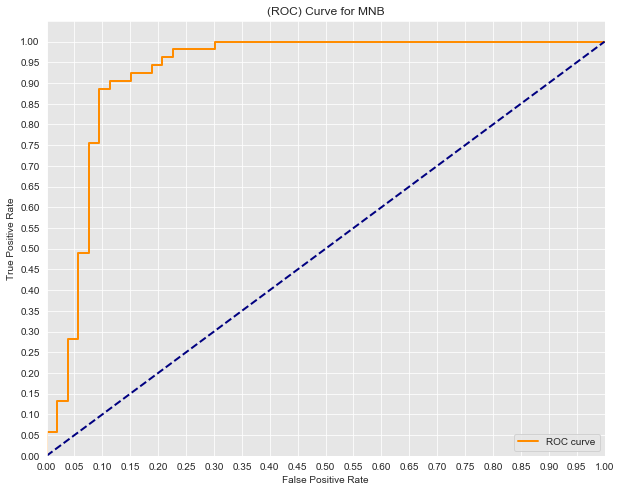

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


y_score= mb_model_resampled.predict_proba(X_resampled_Cat)
fpr, tpr, thresholds = roc_curve(y_resampled_BC, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for MNB')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [82]:
mb_all_predictions_resampled = mb_model_resampled.predict(X_resampled_Cat)
print(mb_all_predictions_resampled)

['hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 '

In [83]:
print(classification_report(y_resampled_Cat, mb_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       1.00      0.68      0.81        53
     hawkish       0.76      1.00      0.86        53

   micro avg       0.84      0.84      0.84       106
   macro avg       0.88      0.84      0.84       106
weighted avg       0.88      0.84      0.84       106



In [85]:
mb_model_resampled.score(X_resampled_Cat, y_resampled_Cat)

0.839622641509434

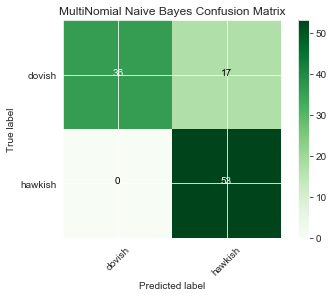

In [84]:
cf1 = confusion_matrix(y_resampled_Cat, mb_all_predictions_resampled)
plt.imshow(cf1, cmap=plt.cm.Greens)

plt.title('MultiNomial Naive Bayes Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y_resampled_Cat)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cf1.max() / 2.

for i, j in product(range(cf1.shape[0]), range(cf1.shape[1])):
    plt.text(j, i, cf1[i, j],
         horizontalalignment="center",
         color="white" if cf1[i, j] > thresh else "black")

plt.colorbar();

## Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
rf_model_resampled = RandomForestClassifier(min_samples_split= 25).fit(X_resampled_Cat, y_resampled_Cat)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [105]:
rf_all_predictions_resampled = rf_model_resampled.predict(X_resampled_Cat)
print(rf_all_predictions_resampled)

['dovish' 'dovish' 'hawkish' 'hawkish' 'hawkish' 'dovish' 'hawkish'
 'dovish' 'hawkish' 'dovish' 'hawkish' 'dovish' 'dovish' 'dovish'
 'hawkish' 'dovish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkis

In [106]:
from sklearn.metrics import classification_report
print(classification_report(y_resampled_Cat, rf_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       0.98      0.96      0.97        53
     hawkish       0.96      0.98      0.97        53

   micro avg       0.97      0.97      0.97       106
   macro avg       0.97      0.97      0.97       106
weighted avg       0.97      0.97      0.97       106



In [107]:
rf_model_resampled.score(X_resampled_Cat, y_resampled_Cat)

0.9716981132075472

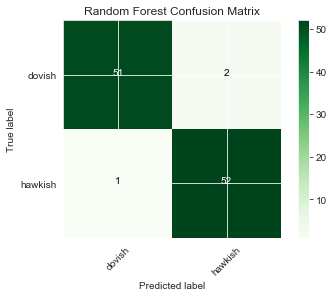

In [109]:
cf1 = confusion_matrix(y_resampled_Cat, rf_all_predictions_resampled)
plt.imshow(cf1, cmap=plt.cm.Greens)

plt.title('Random Forest Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y_resampled_Cat)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cf1.max() / 2.

for i, j in product(range(cf1.shape[0]), range(cf1.shape[1])):
    plt.text(j, i, cf1[i, j],
         horizontalalignment="center",
         color="white" if cf1[i, j] > thresh else "black")

plt.colorbar();

AUC: 0.9982200071199715


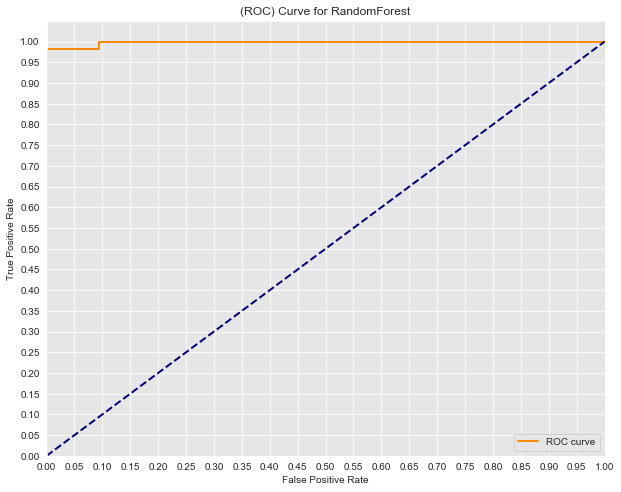

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


y_score= rf_model_resampled.predict_proba(X_resampled_BC)
fpr, tpr, thresholds = roc_curve(y_resampled_BC, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for RandomForest')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

## Logistic Regression 

In [506]:
# from sklearn.metrics import roc_curve, auc

# #for various decision boundaries given the case member probabilites

# #First calculate the probability scores of each of the datapoints:
# y_score = mb_model_resampled.decision_function(X_resampled)

# fpr, tpr, thresholds = roc_curve(y_resampled, y_score)

# y_train_score = mb_model_resampled.decision_function(X_train)
# train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

In [117]:
from sklearn.linear_model import LogisticRegression

In [122]:
lr_model_resampled = LogisticRegression().fit(X_resampled_Cat,y_resampled_Cat)

In [123]:
lr_all_predictions_resampled = lr_model_resampled.predict(X_resampled_Cat)
print(lr_all_predictions_resampled)

['dovish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'h

In [125]:
from sklearn.metrics import classification_report
print(classification_report(y_resampled_Cat, lr_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       1.00      0.70      0.82        53
     hawkish       0.77      1.00      0.87        53

   micro avg       0.85      0.85      0.85       106
   macro avg       0.88      0.85      0.85       106
weighted avg       0.88      0.85      0.85       106



In [127]:
lr_model_resampled.score(X_resampled_Cat, y_resampled_Cat)

0.8490566037735849

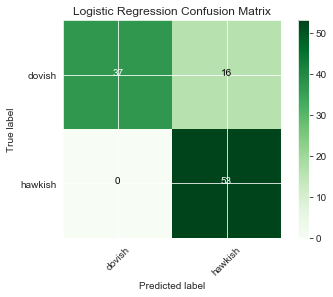

In [136]:
cf1 = confusion_matrix(y_resampled_Cat, lr_all_predictions_resampled)
plt.imshow(cf1, cmap=plt.cm.Greens)

plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y_resampled_Cat)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cf1.max() / 2.

for i, j in product(range(cf1.shape[0]), range(cf1.shape[1])):
    plt.text(j, i, cf1[i, j],
         horizontalalignment="center",
         color="white" if cf1[i, j] > thresh else "black")

plt.colorbar();

AUC: 0.9515841936632254


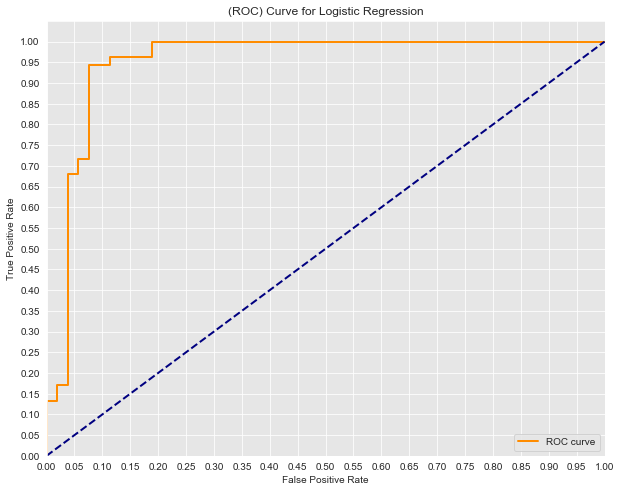

In [146]:
# Your code here
from sklearn.metrics import roc_curve, auc

#for various decision boundaries given the case member probabilites

#First calculate the probability scores of each of the datapoints:
# y_score = lr_model_resampled.decision_function(X_resampled_BC)

y_score= lr_model_resampled.predict_proba(X_resampled_BC)
fpr, tpr, thresholds = roc_curve(y_resampled_BC, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

# Making Preditions with Our Model
We will pass quotes from characters in Games of Thrones, to see if our model can predict if the character is Dovish or Hawkish.

In [218]:
game_of_thrones = {
    'tyrion_lannister': "My brother has his sword, King Robert has his warhammer and I have my mind...and a mind needs books as a sword needs a whetstone if it is to keep its edge. That's why I read so much Jon Snow.",
    'jon_snow': "The more you give a king, the more he wants. We are walking on a bridge of ice with an abyss on either side. Pleasing one king is difficult enough, pleasing two is hardly possible.",
    'daenerys_targaryen': "I am Daenerys Stormborn of House Targaryen, of the blood of Old Valyeria. I am the dragon's daughter, and I swear to you that those who would harm you will die screaming.",
    'joffrey_baratheon': "I am the king! I will punish you.",
    'lord_of_ice_and_the_wardrobe': "The Well of the High Castle: The War fits into the Lion's song, and shelter us human, and power. Peter was the destiny and literature is miserable. His parents are every turn, and his own transition, Borlú of the best efforts of the creature's hideousness."}

In [219]:
def mb_predictions(document):
    X = vectorizer.transform([document])
    documents_tfidf = tfidf_transformer.transform(X)
    return mb_model_resampled.predict(documents_tfidf)[0]

In [220]:
def mb_got_characters():
    for character, quote in game_of_thrones.items():
        print(f'{" ".join(character.title().split("_"))} is {mb_predictions(quote).title()}')

# def mb_got_characters():
#     lst = []
#     for character, quote in game_of_thrones.items():
#         if mb_predictions(quote) == 0:
#             lst.append(f'{character.title()}: Dovish')
#         else:
#             lst.append(f'{character.title()}: Hawkish')
#     return lst

In [221]:
mb_got_characters()

Tyrion Lannister is Hawkish
Jon Snow is Dovish
Daenerys Targaryen is Dovish
Joffrey Baratheon is Dovish
Lord Of Ice And The Wardrobe is Dovish


In [222]:
def got_characters_predictions(model):
    for character, quote in game_of_thrones.items():
        if model== 'mb':
            print(f'{" ".join(character.title().split("_"))} is {mb_predictions(quote).title()}')
        elif model == 'lr':
            print(f'{" ".join(character.title().split("_"))} is {lr_predictions(quote).title()}')     
        elif model == 'rf':
            print(f'{" ".join(character.title().split("_"))} is {rf_predictions(quote).title()}')
        else:
            print('This is not a recognizable model')

In [230]:
got_characters_predictions('mb')

Tyrion Lannister is Hawkish
Jon Snow is Dovish
Daenerys Targaryen is Dovish
Joffrey Baratheon is Dovish
Lord Of Ice And The Wardrobe is Dovish
